# Sensitivity Analysis

This notebook is used to do the sensitivity analysis. The cell below defines all the different experiments and puts the experiments in a list. The values are based on
the default values of the model.


In [ ]:

# Sensitivity Analysis
import pandas as pd
from mesa.batchrunner import batch_run
from solara import display

from Model import EvacuationDec
import matplotlib.pyplot as plt
import glob
import os
import matplotlib as mpl
# Define the names of the variables we want to change
variabless = ['comm_watch_value_risk',
              'comm_warning_value_risk',
              'comm_watch_value_imm' ,
              'comm_warning_value_imm',
              'coeff_risk_perception']

# Define different values for the variables
parameters_n_neighbors = {"outcome_collection":["SingleRun"], "n_neighbors": [8, 10, 12]}
parameters_comm_watch_value_risk = {"outcome_collection":["SingleRun"], "comm_watch_value_risk": [0.04, 0.05, 0.06]}
parameters_comm_warning_value_risk = {"outcome_collection":["SingleRun"], "comm_warning_value_risk": [0.16, 0.2, 0.24]}
parameters_comm_watch_value_imm = {"outcome_collection":["SingleRun"], "comm_watch_value_imm": [0.008, 0.01, 0.012]}
parameters_comm_warning_value_imm = {"outcome_collection":["SingleRun"], "comm_warning_value_imm": [0.04, 0.05, 0.06]}
parameters_coeff_risk_perception = {"outcome_collection":["SingleRun"], "coeff_risk_perception": [0.8, 1, 1.2]}
parameters_ceiling = {"outcome_collection":["SingleRun"], "ceiling": [0.32, 0.4, 0.48]}
parameters_coeff_action_comm = {"outcome_collection":["SingleRun"], "coeff_action_comm": [0.8, 1, 1.2]}
parameters_grow_factor = {"outcome_collection":["SingleRun"], "grow_factor": [24, 30, 36]}
parameters_phase_change_factor = {"outcome_collection":["SingleRun"], "phase_change_factor": [0.08, 0.1, 0.12]}
parameters_action_comm_value_imm = {"outcome_collection":["SingleRun"], "action_comm_value_imm": [0.008, 0.01, 0.012]}
parameters_action_comm_value = {"outcome_collection":["SingleRun"], "action_comm_value": [0.08, 0.1, 0.12]}
parameters_media_weight_trust = {"outcome_collection":["SingleRun"], "media_weight_trust": [0.032, 0.04, 0.048]}
parameters_media_weight_perc = {"outcome_collection":["SingleRun"], "media_weight_perc": [0.2, 0.25, 0.3]}
parameters_RA_base = {"outcome_collection":["SingleRun"], "RA_base": [0.4, 0.5, 0.6]}
parameters_RI_base = {"outcome_collection":["SingleRun"], "RI_base": [0.16, 0.2, 0.24]}
parameters_threshold_strength_RI = {"outcome_collection":["SingleRun"], "threshold_strength_RI": [0.8, 1, 1.2]}
parameters_threshold_strength_RA = {"outcome_collection":["SingleRun"], "threshold_strength_RA": [0.32, 0.4, 0.48]}
parameters_env_strength = {"outcome_collection":["SingleRun"], "env_strength": [0.16, 0.2, 0.24]}

para_list = [parameters_n_neighbors,
parameters_comm_watch_value_risk,
parameters_comm_warning_value_risk,
parameters_comm_watch_value_imm,
parameters_comm_warning_value_imm,
parameters_coeff_risk_perception,
parameters_ceiling,
parameters_coeff_action_comm,
parameters_grow_factor,
parameters_phase_change_factor,
parameters_action_comm_value_imm,
parameters_action_comm_value,
parameters_media_weight_trust,
parameters_media_weight_perc,
parameters_RA_base,
parameters_RI_base,
parameters_threshold_strength_RI,
parameters_threshold_strength_RA,
parameters_env_strength
             ]



The cell below runs a sensitivity analysis for the defined expierments above. The `sensitivity_analysis` function takes a parameter dictionary, performs multiple batch simulations by varying the selected parameter (typically at -20%, baseline, and +20% values), and extracts the resulting changes in key outcome variables. For each parameter value, it calculates the relative percentage change compared to the baseline, then saves the summarized results to a CSV file for further examination. The sensitivity analysis helps identify which parameters most influence model outcomes and provides insight into model robustness and critical drivers.

<span style="color:red"> The results are saved, so the cell can be skipped if rerunning the analysis is not required.  </span>.


In [2]:
def sensitivity_analysis(parameter):
    print(f"Run for {parameter}")
    # We want to do a sensitivity analysis for all variables in the parameter_list
    # Run the batchrunner for the variable
    key =list(parameter.keys())[1]
    # for value in parameter[key]:
    result_batch = batch_run(
    EvacuationDec,
    parameters=parameter,
    iterations=150,
    max_steps=89,
    number_processes= None,
    data_collection_period=1,
    display_progress=True,
    )
    df_sensitivity = pd.DataFrame(result_batch)
    df = df_sensitivity[df_sensitivity["Step"]==df_sensitivity["Step"].max()]
    df_grouped = df[['average_evac_time', 'hotel_choice', 'friends_choice','shelter_choice',"stay_choice",key]].groupby(by=key).mean()
    df_grouped = df_grouped.transpose()
    df_grouped.columns = ["-20%","Base","20%"]
    df_grouped["-20%"] = (df_grouped["-20%"] - df_grouped["Base"])/df_grouped["Base"] * 100
    df_grouped["20%"] =(df_grouped["20%"] - df_grouped["Base"])/df_grouped["Base"] * 100
    df_grouped["parameter"] = key
    df_grouped.to_csv(f"archives/senstivity_runs/{key}.csv")
    del result_batch, df_sensitivity, df, df_grouped

for parameter in para_list :
    results = sensitivity_analysis(parameter)

This cell below aggregates and visualizes the results of a sensitivity analysis conducted on simulation model parameters. It reads all sensitivity CSV output files, combines them, and generates two main visualizations:
1. **Decision Outcomes (2x2 Grid of Plots):**
Each subplot shows the percentage change in the fraction of agents choosing each evacuation option ("Friends Choice", "Hotel Choice", "Shelter Choice", "Stay Choice") when varying model parameters by -20% and +20% from the baseline. Stem plots allow comparison of the impact different parameters have on each choice, helping to identify which factors most shift individual decision preferences.
2. **Average Evacuation Time (Single Plot):**
This plot shows how the average evacuation time responds to parameter changes, with the y-axis restricted for clarity. This identifies which parameters most influence the evacuation speed in the simulated scenarios.

All plots use color-coded markers for decrease ("-20%") and increase ("20%") in parameter values, with clear legends for easy interpretation. The approach helps prioritize model parameters by their influence on critical outcome variables.


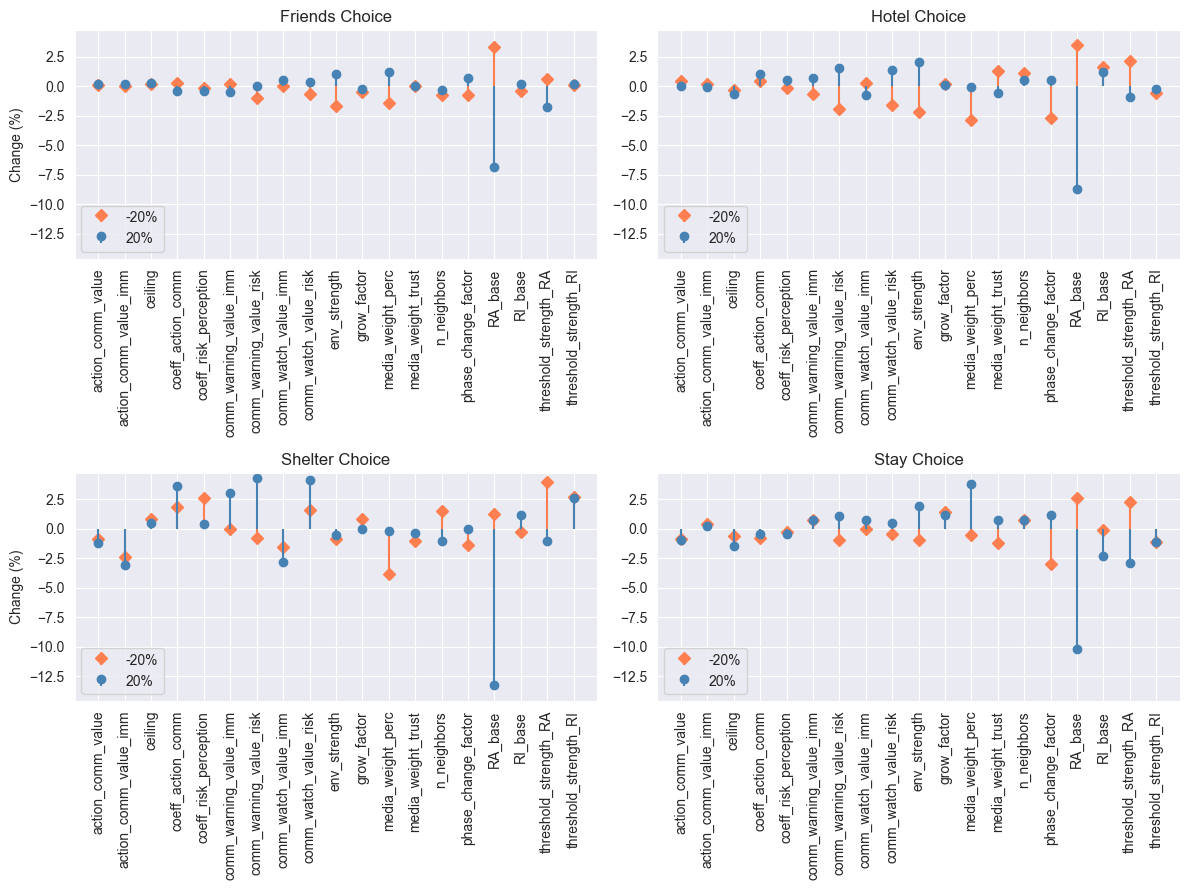

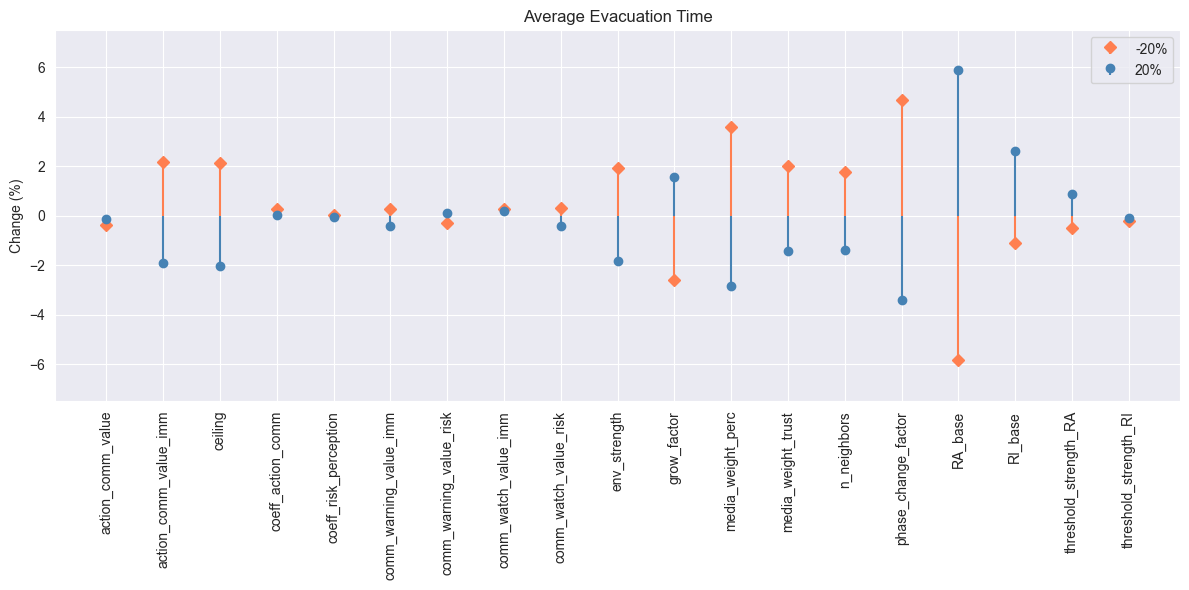

In [14]:
# Path to the folder containing the CSVs
csv_folder = "archives/senstivity_runs"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))

# Read and concatenate CSV files
df_all = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

# Show the combined DataFrame
df_resultss = df_all

    # Path to the folder containing the CSVs
csv_folder = "archives/senstivity_runs"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))

# Read and concatenate CSV files
df_all = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

# Show the combined DataFrame
df_resultss = df_all

average_evac_time_df = df_resultss[df_resultss['Unnamed: 0'] == 'average_evac_time']
friends_choice_df = df_resultss[df_resultss['Unnamed: 0'] == 'friends_choice']
hotel_choice_df = df_resultss[df_resultss['Unnamed: 0'] == 'hotel_choice']
shelter_choice_df = df_resultss[df_resultss['Unnamed: 0'] == 'shelter_choice']
stay_choice_df = df_resultss[df_resultss['Unnamed: 0'] == 'stay_choice']

# Create first figure with 2x2 grid
fig1, axes = plt.subplots(2, 2, figsize=(12, 9))
titles = ['Friends Choice', 'Hotel Choice', 'Shelter Choice', 'Stay Choice']
dfs = [friends_choice_df, hotel_choice_df, shelter_choice_df, stay_choice_df]

# Find global min/max for y-axis
y_min = min([df['-20%'].min() for df in dfs] + [df['20%'].min() for df in dfs])
y_max = max([df['-20%'].max() for df in dfs] + [df['20%'].max() for df in dfs])
y_range = [y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1]  # Add 10% padding

for i, (ax, title, df) in enumerate(zip(axes.flat, titles, dfs)):
    ax.stem(df['parameter'].astype(str), df['-20%'], linefmt='#FF7F50', markerfmt='D', basefmt=" ",
            label='-20%')
    ax.stem(df['parameter'].astype(str), df['20%'], linefmt='#4682B4', markerfmt='o', basefmt=" ", label='20%')
    if i % 2 == 0:
        ax.set_ylabel('Change (%)')
    ax.set_title(title)
    ax.set_ylim(y_range)
    ax.legend(['-20%', '20%'])
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Create second figure for Average Evacuation Time
fig2, ax1 = plt.subplots(figsize=(12, 6))
df = average_evac_time_df
ax1.set_ylim(-7.5,7.5)
ax1.stem(df['parameter'].astype(str), df['-20%'], linefmt='#FF7F50', markerfmt='D', basefmt=" ",
        label='-20%')
ax1.stem(df['parameter'].astype(str), df['20%'], linefmt='#4682B4', markerfmt='o', basefmt=" ", label='20%')
ax1.set_ylabel('Change (%)')
ax1.set_title("Average Evacuation Time")
ax1.legend(['-20%', '20%'])
ax1.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()